In [358]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, make_scorer, recall_score, precision_score, classification_report, precision_recall_fscore_support
import pandas as pd
import numpy as np
import pickle, csv, sklearn
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
comments = pd.read_csv('data/formspring_data_1.csv',sep = '\t')
comments.head()

,userid,post,ques,ans,asker,ans1,severity1,ans2,severity2,ans3,severity3
0,aguitarplayer94,Q: what&#039;s your favorite song? :D<br>A: I ...,what&#039;s your favorite song? :D<br>,I like too many songs to have a favorite,None,No,0,No,0,No,0
1,aprilpooh15,Q: <3<br>A: </3 ? haha jk! <33,<3,</3 ? haha jk! <33,None,No,0,No,0,No,0
2,aprilpooh15,Q: &quot;hey angel you duh sexy&quot;<br>A: R...,&quot;hey angel you duh sexy&quot;,Really?!?! Thanks?! haha,None,No,0,No,0,No,0
3,aprilpooh15,Q: (:<br>A: ;(,(:,;(,None,No,0,No,0,No,0
4,aprilpooh15,Q: ******************MEOWWW*******************...,******************MEOWWW*************************,*RAWR*?,None,No,0,No,0,No,0


In [318]:
def get_label(post):
    label = 1 if ((post.ans1 == "Yes" and post.ans2 == "Yes") or (post.ans2 == "Yes" and post.ans3 == "Yes") or (post.ans1 == "Yes" and post.ans3 == "Yes")) else 0
    return label
comments['attack'] = comments.apply(get_label, axis=1)

In [319]:
import string
comments['post'] = comments['post'].apply(lambda x: x.replace('Q:',' ').replace('A:',' ').replace('<br>',' '))
comments['post'] = comments['post'].apply(lambda x: x.replace(':D',' '))
comments['post'] = comments['post'].apply(lambda x: "".join(l for l in x if l not in string.punctuation))
comments['post']=comments['post'].apply(lambda x: "".join(l for l in x if not l.isdigit()))
comments['post']=comments['post'].apply(lambda x:"".join(x).lower())

In [320]:
comments.head()

,userid,post,ques,ans,asker,ans1,severity1,ans2,severity2,ans3,severity3,attack
0,aguitarplayer94,whats your favorite song i like too many...,what&#039;s your favorite song? :D<br>,I like too many songs to have a favorite,None,No,0,No,0,No,0,0
1,aprilpooh15,haha jk,<3,</3 ? haha jk! <33,None,No,0,No,0,No,0,0
2,aprilpooh15,quothey angel you duh sexyquot really tha...,&quot;hey angel you duh sexy&quot;,Really?!?! Thanks?! haha,None,No,0,No,0,No,0,0
3,aprilpooh15,,(:,;(,None,No,0,No,0,No,0,0
4,aprilpooh15,meowww rawr,******************MEOWWW*************************,*RAWR*?,None,No,0,No,0,No,0,0


In [321]:
comments=comments[['userid','post','asker','attack']]

In [322]:
comments.head()

,userid,post,asker,attack
0,aguitarplayer94,whats your favorite song i like too many...,None,0
1,aprilpooh15,haha jk,None,0
2,aprilpooh15,quothey angel you duh sexyquot really tha...,None,0
3,aprilpooh15,,None,0
4,aprilpooh15,meowww rawr,None,0


(array([ 11997.,    776.]),
 array([ 0. ,  0.5,  1. ]),
 <a list of 2 Patch objects>)

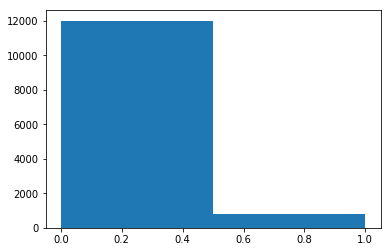

In [323]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(comments.attack,bins=2)

In [324]:
def load_data(filename):
    data = pickle.load(open(filename, 'rb'))
    print(len(data))
    x_text = []
    labels = []
    for i in range(len(data)):
        x_text.append(data[i]['text'])
        labels.append(data[i]['label'])
    return x_text,labels

In [338]:
x_text,labels=load_data('data/formspring_data.pkl')

12773


In [347]:
def data_archietecture(type_of):
    if type_of=='unigram':
        unigram_bag_of_words_transform=CountVectorizer(analyzer="word",max_features = 10000,stop_words='english').fit(x_text)
        unigram_comments_bag_of_words = unigram_bag_of_words_transform.transform(x_text)
        unigram_tfidf_transformer = TfidfTransformer(norm = 'l2').fit(unigram_comments_bag_of_words)
        unigram_comments_tfidf = unigram_tfidf_transformer.transform(unigram_comments_bag_of_words)
        unigram_features = unigram_comments_tfidf
        return unigram_features,unigram_bag_of_words_transform
    elif type_of=='bigram':
        bigram_bag_of_words_transform=CountVectorizer(max_features = 10000,ngram_range=(1,2)).fit(x_text)
        bigram_comments_bag_of_words = bigram_bag_of_words_transform.transform(x_text)
        bigram_tfidf_transformer = TfidfTransformer(norm = 'l2').fit(bigram_comments_bag_of_words)
        bigram_comments_tfidf = bigram_tfidf_transformer.transform(bigram_comments_bag_of_words)
        bigram_features = bigram_comments_tfidf
        return bigram_features,bigram_bag_of_words_transform

In [348]:
unigram_features,unigram_bag_of_words_transform=data_archietecture('unigram')
bigram_features,bigram_bag_of_words_transform=data_archietecture('bigram')

In [341]:
print(Counter(unigram_bag_of_words_transform.get_feature_names()))

Counter({'00': 1, '000': 1, '00am': 1, '04': 1, '06': 1, '07pm': 1, '09': 1, '0f': 1, '0ff': 1, '0m3': 1, '0n': 1, '0n3': 1, '0nc3': 1, '0o0o': 1, '0oo0o0o0o0o0oh': 1, '0p': 1, '0py': 1, '0rq': 1, '0u': 1, '10': 1, '100': 1, '1000': 1, '10000': 1, '1000000000': 1, '100000175835119': 1, '100000541053909': 1, '1000th': 1, '100mph': 1, '101': 1, '102': 1, '1020pm': 1, '104': 1, '10am': 1, '10ish': 1, '10million': 1, '10pm': 1, '10th': 1, '11': 1, '110': 1, '11088742': 1, '111': 1, '115': 1, '119': 1, '11pm': 1, '11th': 1, '12': 1, '1227': 1, '123': 1, '1268455047431': 1, '127': 1, '1271302129': 1, '12am': 1, '12th': 1, '13': 1, '130': 1, '1321183660599798844': 1, '134': 1, '1364196778993': 1, '138': 1, '1386': 1, '13th': 1, '14': 1, '143194749024286': 1, '144': 1, '14ish': 1, '14steps': 1, '15': 1, '150': 1, '1500': 1, '15496984': 1, '15743111': 1, '15x15': 1, '16': 1, '1601024519': 1, '160952': 1, '163949988': 1, '1641': 1, '16444872': 1, '16463192': 1, '16955552': 1, '16th': 1, '16year'

In [342]:
print(Counter(bigram_bag_of_words_transform.get_feature_names()))

Counter({'00': 1, '00 am': 1, '00 and': 1, '00 do': 1, '00 h0': 1, '00 in': 1, '00 what': 1, '000': 1, '000 000': 1, '000 and': 1, '000 blow': 1, '000 budget': 1, '000 car': 1, '000 dollars': 1, '000 for': 1, '000 here': 1, '000 if': 1, '000 month': 1, '000 or': 1, '000 people': 1, '000 shopping': 1, '000 to': 1, '000 week': 1, '000 what': 1, '000 yall': 1, '000 years': 1, '00am': 1, '00am who': 1, '04': 1, '04 10': 1, '04 2010': 1, '06': 1, '06 and': 1, '07pm': 1, '09': 1, '09 duckroll': 1, '09 still': 1, '0f': 1, '0f cum': 1, '0ff': 1, '0ff hump': 1, '0ff m00n': 1, '0m3': 1, '0m3 ish': 1, '0m3 r3': 1, '0n': 1, '0n d3': 1, '0n lol': 1, '0n m0nd': 1, '0n r3': 1, '0n y0': 1, '0n3': 1, '0n3 lmfao': 1, '0nc3': 1, '0nc3 ly': 1, '0o0o': 1, '0o0o m3': 1, '0oo0o0o0o0o0oh': 1, '0oo0o0o0o0o0oh h3yyyyyy': 1, '0p': 1, '0p ly': 1, '0py': 1, '0py playnext': 1, '0rq': 1, '0rq f0r': 1, '0rq mhm': 1, '0rq nd': 1, '0rq r3': 1, '0rq ur3': 1, '0rq y3': 1, '0rq zz': 1, '0u': 1, '0u fr0m': 1, '0u kum': 1, 

In [349]:
XU_train, XU_test, yu_train, yu_test = train_test_split(unigram_features,labels, test_size= 0.2, random_state=13)
XB_train, XB_test, yb_train, yb_test = train_test_split(bigram_features, labels, test_size= 0.2, random_state=13)

In [350]:
def get_model(m_type):
    if m_type == 'lr':
        logreg = LogisticRegression()
    elif m_type == 'naive':
        logreg =  MultinomialNB()
    elif m_type == "random_forest":
        logreg = RandomForestClassifier(n_estimators=100)
    elif m_type == "svm":
        logreg = LinearSVC()
    else:
        print("ERROR: Please specify a correst model")
        return None
    return logreg

In [351]:
def get_scores(y_true, y_pred):
    return np.array([ 
            precision_score(y_true, y_pred, average=None), 
            recall_score(y_true, y_pred,  average=None),
            f1_score(y_true, y_pred, average=None)])

In [363]:
log_reg=get_model('lr')
print("Logistic Regression for unigram model")
log_reg.fit(XU_train,yu_train)
yu_pred = logreg.predict(XU_test)
curr_scores = get_scores(yu_test, yu_pred)
print("Confusion matrix for unigram model\n{}\n".format(confusion_matrix(yu_test, yu_pred)))
print("Confusion matrix for unigram model\n{}\n".format(classification_report(yu_test, yu_pred)))

print("---------------------------------------------------------------------------------------")

print("Logistic Regression for bigram model")
log_reg.fit(XB_train,yb_train)
yb_pred = logreg.predict(XB_test)
curr_scores = get_scores(yb_test, yb_pred)
print("Confusion matrix for bigram model\n{}".format(confusion_matrix(yb_test, yb_pred)))
print("Confusion matrix for bigram model\n{}".format(classification_report(yb_test, yb_pred)))

Logistic Regression for unigram model
Confusion matrix for unigram model
[[2297  108]
 [  78   72]]

Confusion matrix for unigram model
             precision    recall  f1-score   support

          0       0.97      0.96      0.96      2405
          1       0.40      0.48      0.44       150

avg / total       0.93      0.93      0.93      2555


---------------------------------------------------------------------------------------
Logistic Regression for bigram model
Confusion matrix for bigram model
[[2381   24]
 [ 150    0]]
Confusion matrix for bigram model
             precision    recall  f1-score   support

          0       0.94      0.99      0.96      2405
          1       0.00      0.00      0.00       150

avg / total       0.89      0.93      0.91      2555



In [364]:
naive=get_model('naive')
print("Logistic Regression for unigram model")
naive.fit(XU_train,yu_train)
yu_pred = naive.predict(XU_test)
curr_scores = get_scores(yu_test, yu_pred)
print("Confusion matrix for unigram model\n{}\n".format(confusion_matrix(yu_test, yu_pred)))
print("Confusion matrix for unigram model\n{}\n".format(classification_report(yu_test, yu_pred)))

print("---------------------------------------------------------------------------------------")

print("Logistic Regression for bigram model")
naive.fit(XB_train,yb_train)
yb_pred = naive.predict(XB_test)
curr_scores = get_scores(yb_test, yb_pred)
print("Confusion matrix for bigram model\n{}".format(confusion_matrix(yb_test, yb_pred)))
print("Confusion matrix for bigram model\n{}".format(classification_report(yb_test, yb_pred)))

Logistic Regression for unigram model
Confusion matrix for unigram model
[[2404    1]
 [ 149    1]]

Confusion matrix for unigram model
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      2405
          1       0.50      0.01      0.01       150

avg / total       0.92      0.94      0.91      2555


---------------------------------------------------------------------------------------
Logistic Regression for bigram model
Confusion matrix for bigram model
[[2405    0]
 [ 147    3]]
Confusion matrix for bigram model
             precision    recall  f1-score   support

          0       0.94      1.00      0.97      2405
          1       1.00      0.02      0.04       150

avg / total       0.95      0.94      0.92      2555



In [366]:
random_forest=get_model('random_forest')
print("Logistic Regression for unigram model")
random_forest.fit(XU_train,yu_train)
yu_pred = random_forest.predict(XU_test)
curr_scores = get_scores(yu_test, yu_pred)
print("Confusion matrix for unigram model\n{}\n".format(confusion_matrix(yu_test, yu_pred)))
print("Confusion matrix for unigram model\n{}\n".format(classification_report(yu_test, yu_pred)))

print("---------------------------------------------------------------------------------------")

print("Logistic Regression for bigram model")
random_forest.fit(XB_train,yb_train)
yb_pred = random_forest.predict(XB_test)
curr_scores = get_scores(yb_test, yb_pred)
print("Confusion matrix for bigram model\n{}".format(confusion_matrix(yb_test, yb_pred)))
print("Confusion matrix for bigram model\n{}".format(classification_report(yb_test, yb_pred)))

Logistic Regression for unigram model
Confusion matrix for unigram model
[[2396    9]
 [ 123   27]]

Confusion matrix for unigram model
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      2405
          1       0.75      0.18      0.29       150

avg / total       0.94      0.95      0.93      2555


---------------------------------------------------------------------------------------
Logistic Regression for bigram model
Confusion matrix for bigram model
[[2397    8]
 [ 124   26]]
Confusion matrix for bigram model
             precision    recall  f1-score   support

          0       0.95      1.00      0.97      2405
          1       0.76      0.17      0.28       150

avg / total       0.94      0.95      0.93      2555



In [365]:
svm=get_model('svm')
print("Logistic Regression for unigram model")
svm.fit(XU_train,yu_train)
yu_pred = svm.predict(XU_test)
curr_scores = get_scores(yu_test, yu_pred)
print("Confusion matrix for unigram model\n{}\n".format(confusion_matrix(yu_test, yu_pred)))
print("Confusion matrix for unigram model\n{}\n".format(classification_report(yu_test, yu_pred)))

print("---------------------------------------------------------------------------------------")

print("Logistic Regression for bigram model")
svm.fit(XB_train,yb_train)
yb_pred = svm.predict(XB_test)
curr_scores = get_scores(yb_test, yb_pred)
print("Confusion matrix for bigram model\n{}".format(confusion_matrix(yb_test, yb_pred)))
print("Confusion matrix for bigram model\n{}".format(classification_report(yb_test, yb_pred)))

Logistic Regression for unigram model
Confusion matrix for unigram model
[[2387   18]
 [ 105   45]]

Confusion matrix for unigram model
             precision    recall  f1-score   support

          0       0.96      0.99      0.97      2405
          1       0.71      0.30      0.42       150

avg / total       0.94      0.95      0.94      2555


---------------------------------------------------------------------------------------
Logistic Regression for bigram model
Confusion matrix for bigram model
[[2392   13]
 [  99   51]]
Confusion matrix for bigram model
             precision    recall  f1-score   support

          0       0.96      0.99      0.98      2405
          1       0.80      0.34      0.48       150

avg / total       0.95      0.96      0.95      2555



In [375]:
import re
re.search(r'Co\wk\we','Cookie').group()

'Cookie'

In [424]:
re.search(r'*Eat', 'Eatkake').group()

error: nothing to repeat at position 0

In [381]:
re.search(r'\A[A-E]ookie', 'Dookie').group()

'Dookie'

In [384]:
re.search(r'\b[a-e]ookie', 'cookie').group()

'cookie'

In [387]:
re.search(r'Back\\stail', 'Back\stail').group()

'Back\\stail'

In [396]:
re.search(r'Ca+o*kie', 'Caokie').group()

'Caokie'

In [404]:
re.search(r'[A-E]ookie', 'aDookie').group()

AttributeError: 'NoneType' object has no attribute 'group'

In [413]:
sequence2 = "CCake"
pattern = "[A-Z][A-Z]"
re.match(pattern,sequence2).group()

'CC'

In [414]:
email_address = "Please contact us at: support@datacamp.com, xyz@datacamp.com"

#'addresses' is a list that stores all the possible match
addresses = re.findall(r'[\w]+@[\w]+', email_address)
for address in addresses: 
    print(address)

support@datacamp
xyz@datacamp


In [415]:
email_address = "Please contact us at: xyz@datacamp.com xyz@datacamp.com"
new_email_address = re.sub(r'([\w\.-]+)@([\w\.-]+)', r'support@datacamp.com', email_address)
print(new_email_address)

Please contact us at: support@datacamp.com support@datacamp.com


In [420]:
import re
import requests
the_idiot_url = 'https://www.gutenberg.org/files/2638/2638-0.txt'

def get_book(url):
    # Sends a http request to get the text from project Gutenberg
    raw = requests.get(url).text
    # Discards the metadata from the beginning of the book
    start = re.search(r"\*\*\* START OF THIS PROJECT GUTENBERG EBOOK .* \*\*\*",raw ).end()
    print(start)
#     # Discards the metadata from the end of the book
    stop = re.search(r"II", raw).start()
#     # Keeps the relevant text
    text = raw[start:stop]
    return raw

def preprocess(sentence): 
    return re.sub('[^A-Za-z0-9.]+' , ' ', sentence).lower()

book = get_book(the_idiot_url)
processed_book = preprocess(book)
print(processed_book)

608
 the project gutenberg ebook of the idiot by fyodor dostoyevsky this ebook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever. you may copy it give it away or re use it under the terms of the project gutenberg license included with this ebook or online at www.gutenberg.org title the idiot author fyodor dostoyevsky translator eva martin posting date april 5 2012 ebook 2638 release date may 2001 last updated may 13 2017 language english character set encoding utf 8 start of this project gutenberg ebook the idiot produced by martin adamson david widger with corrections by andrew sly the idiot by fyodor dostoyevsky translated by eva martin part i i. towards the end of november during a thaw at nine o clock one morning a train on the warsaw and petersburg railway was approaching the latter city at full speed. the morning was so damp and misty that it was only with great difficulty that the day succeeded in breaking and it was impossible to distinguis